# Simulation vs. Device Comparison

This notebook has been designed to test the simulation modules with respect to device results.

In [1]:
import sys
sys.path.append(
    "/home/ugurc/SynSense Dropbox/Ugurcan Cakal/repos/dynapse1/ctxctl_contrib"
)

import samna.dynapse1 as dyn1

from netgen import Neuron, NetworkGenerator

from rockpool.devices.dynapse import (
    DynapSE1Jax,
    random_spike_train,
    Router,
    Figure,
    DynapSE1SimBoard,
    DynapSE1SimCore,
)

import numpy as np
import jax.numpy as jnp

# - Plotting imports and config
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

/home/ugurc/anaconda3/envs/synsense/lib/python3.8/site-packages/samna
finished bindings


## Configure the simulator

In [2]:
net_gen = NetworkGenerator()

spikegen_ids = [(0, 0, 50), (0, 0, 59), (0, 0, 78)]
spikegens = []
for spikegen_id in spikegen_ids:
    spikegens.append(Neuron(spikegen_id[0], spikegen_id[1], spikegen_id[2], True))

neuron_ids = [
    (1, 0, 20),
    (1, 0, 36),
    (1, 0, 60),
    (3, 0, 107),
    (3, 0, 152),
    (3, 0, 110),
]
neurons = []
for nid in neuron_ids:
    neurons.append(Neuron(nid[0], nid[1], nid[2]))
    

# connect neuron0 to other neurons
net_gen.add_connection(spikegens[0], neurons[0], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(spikegens[0], neurons[1], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(spikegens[0], neurons[2], dyn1.Dynapse1SynType.NMDA)
net_gen.add_connection(spikegens[0], neurons[2], dyn1.Dynapse1SynType.NMDA)
net_gen.add_connection(spikegens[1], neurons[3], dyn1.Dynapse1SynType.NMDA)
net_gen.add_connection(spikegens[1], neurons[4], dyn1.Dynapse1SynType.NMDA)
net_gen.add_connection(spikegens[2], neurons[2], dyn1.Dynapse1SynType.GABA_A)


net_gen.add_connection(neurons[4], neurons[0], dyn1.Dynapse1SynType.GABA_B)
net_gen.add_connection(neurons[4], neurons[0], dyn1.Dynapse1SynType.GABA_B)
net_gen.add_connection(neurons[0], neurons[2], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(neurons[1], neurons[2], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(neurons[4], neurons[2], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(neurons[3], neurons[2], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(neurons[2], neurons[2], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(neurons[2], neurons[2], dyn1.Dynapse1SynType.NMDA)
net_gen.add_connection(neurons[0], neurons[4], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(neurons[4], neurons[3], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(neurons[3], neurons[4], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(neurons[3], neurons[5], dyn1.Dynapse1SynType.AMPA)

net_gen.network

Post neuron (ChipId,coreId,neuronId): incoming connections [(preNeuron,synapseType), ...]
C1c0n20: [('C0c0s50', 'AMPA'), ('C3c0n152', 'GABA_B'), ('C3c0n152', 'GABA_B')]
C1c0n36: [('C0c0s50', 'AMPA')]
C1c0n60: [('C0c0s50', 'NMDA'), ('C0c0s50', 'NMDA'), ('C0c0s78', 'GABA_A'), ('C1c0n20', 'AMPA'), ('C1c0n36', 'AMPA'), ('C3c0n152', 'AMPA'), ('C3c0n107', 'AMPA'), ('C1c0n60', 'AMPA'), ('C1c0n60', 'NMDA')]
C3c0n107: [('C0c0s59', 'NMDA'), ('C3c0n152', 'AMPA')]
C3c0n152: [('C0c0s59', 'NMDA'), ('C1c0n20', 'AMPA'), ('C3c0n107', 'AMPA')]
C3c0n110: [('C3c0n107', 'AMPA')]

## Requirements

In [3]:
connections = Router.get_virtual_connections(net_gen.network)
config = net_gen.make_dynapse1_configuration()
w_in, w_rec, idx_map = Router.get_weight_from_config(
    config, connections, return_maps=True
)

In [4]:
connections

[(50, 1044),
 (50, 1060),
 (50, 1084),
 (50, 1084),
 (78, 1084),
 (59, 3179),
 (59, 3224)]

In [5]:
config

In [6]:
w_in

array([[[0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 2, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 0],
        [0, 0, 1, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

In [7]:
idx_map

{'w_in': {0: (0, 0, 50), 1: (0, 0, 59), 2: (0, 0, 78)},
 'w_rec': {0: (1, 0, 20),
  1: (1, 0, 36),
  2: (1, 0, 60),
  3: (3, 0, 107),
  4: (3, 0, 110),
  5: (3, 0, 152)}}

## Samna Config
If we only have the device configuration object, the FPGA-to-device input connections can be defined explicitly in multiple ways by providing a direct input weight matrix or a list of virtual connections.

In [8]:
modSE_conn = DynapSE1Jax.from_config(config, virtual_connections=connections, default_bias=True)

In [9]:
modSE_win = DynapSE1Jax.from_config(config, w_in=w_in, idx_map_in=idx_map['w_in'], default_bias=True)

## Netgen Config

In [10]:
modSE_netgen = DynapSE1Jax.from_netgen(net_gen, default_bias=True)

## Choose one of the modules

In [11]:
modSE = modSE_win

## Input Spikes

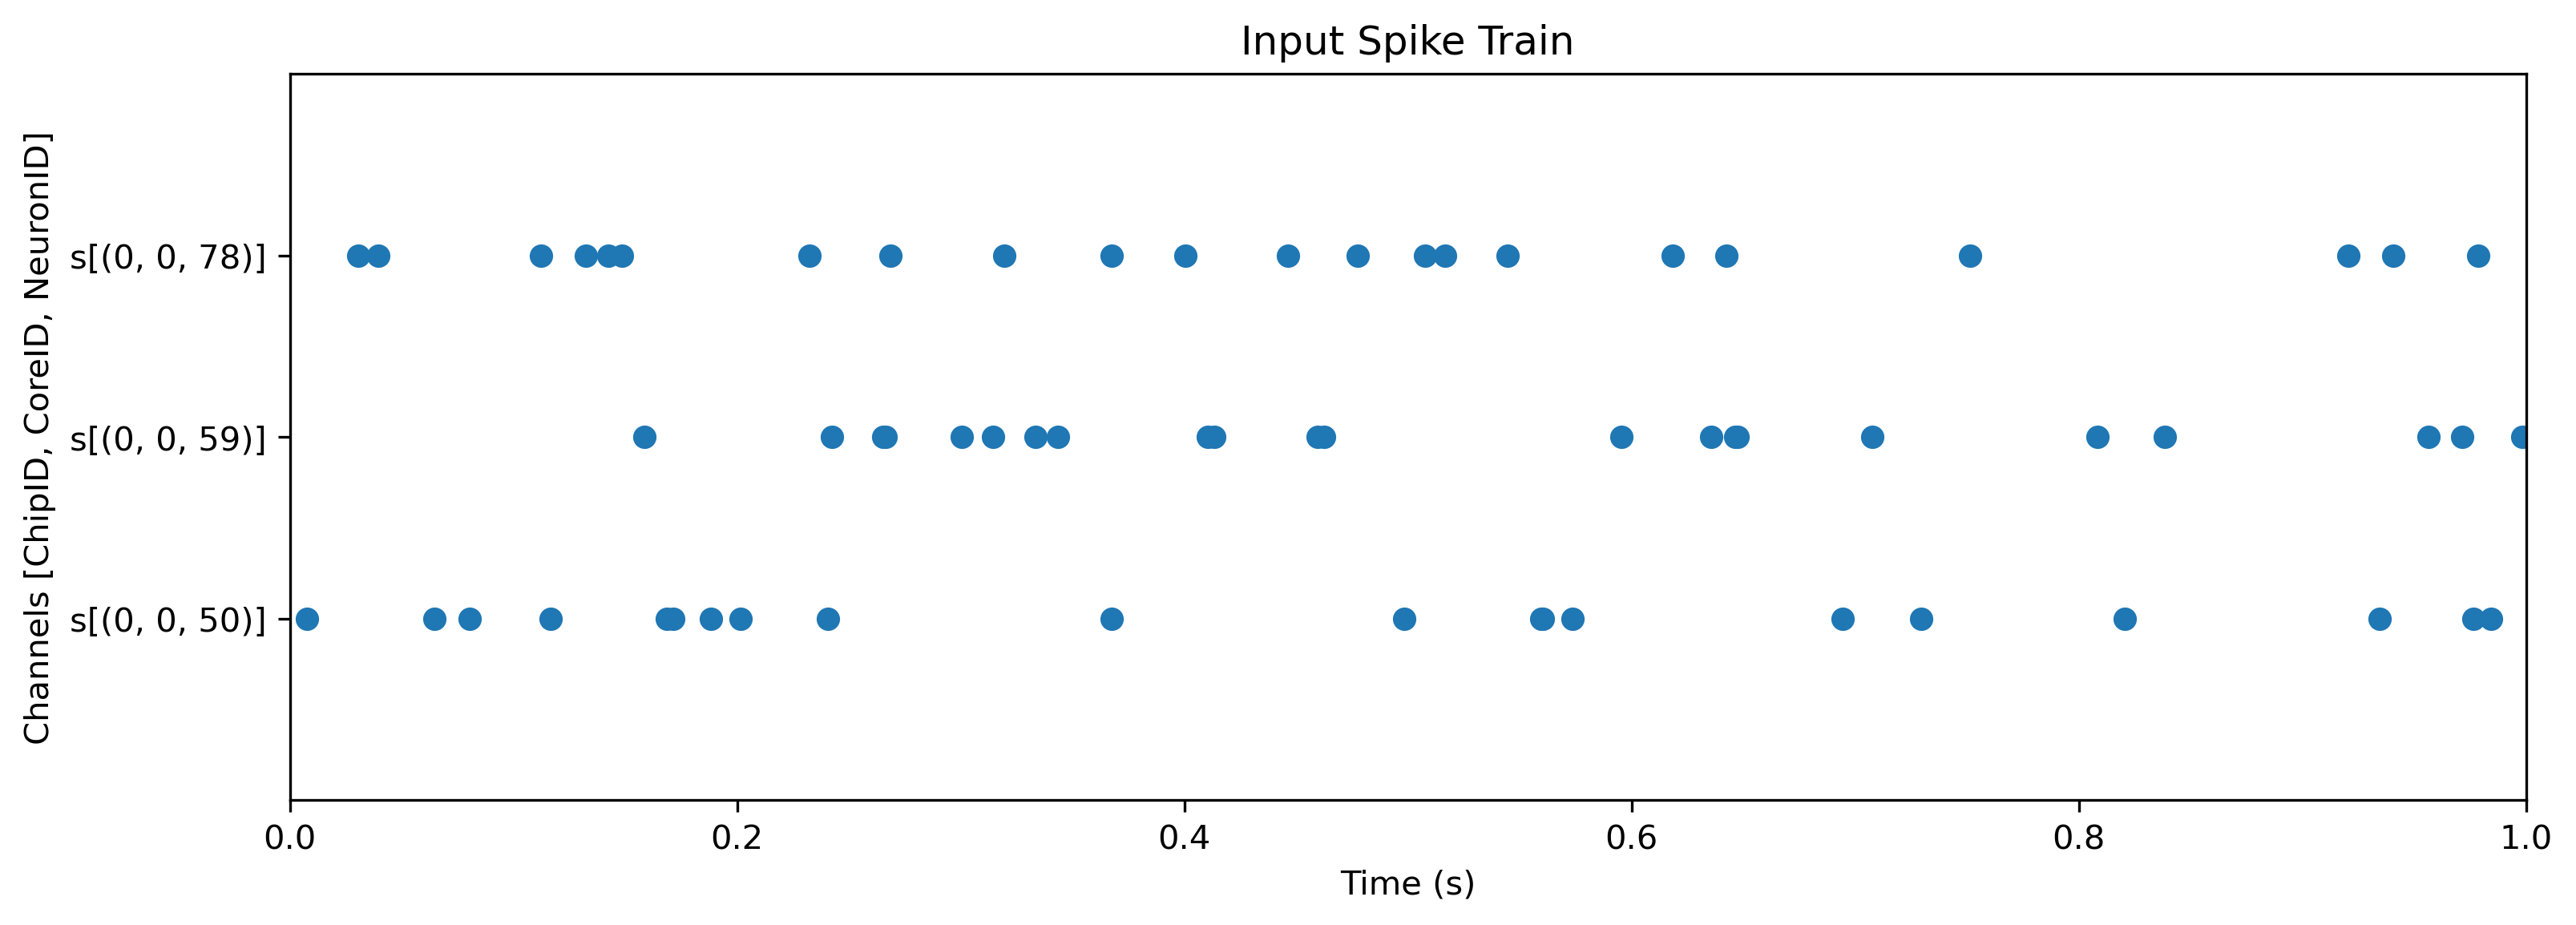

In [12]:
T = 1 # duration in seconds
rate = 20 # firing rate in Hertz

input_ts = random_spike_train(
    duration=T,
    n_channels=len(spikegens),
    rate=rate,
    dt=modSE.dt,
    name='Input Spike Train',
    channel_labels = spikegen_ids
)

input_ts.plot();


## Run the device simulator

In [13]:
out_spikes, new_state, record_dict = modSE(input_ts.raster(dt = modSE.dt))

# Visualize the State Change

non-periodic TSContinuous object `$I_{mem}$  n[(3,0,110)]` from t=0.0 to 1.0. Samples: 1000. Channels: 1

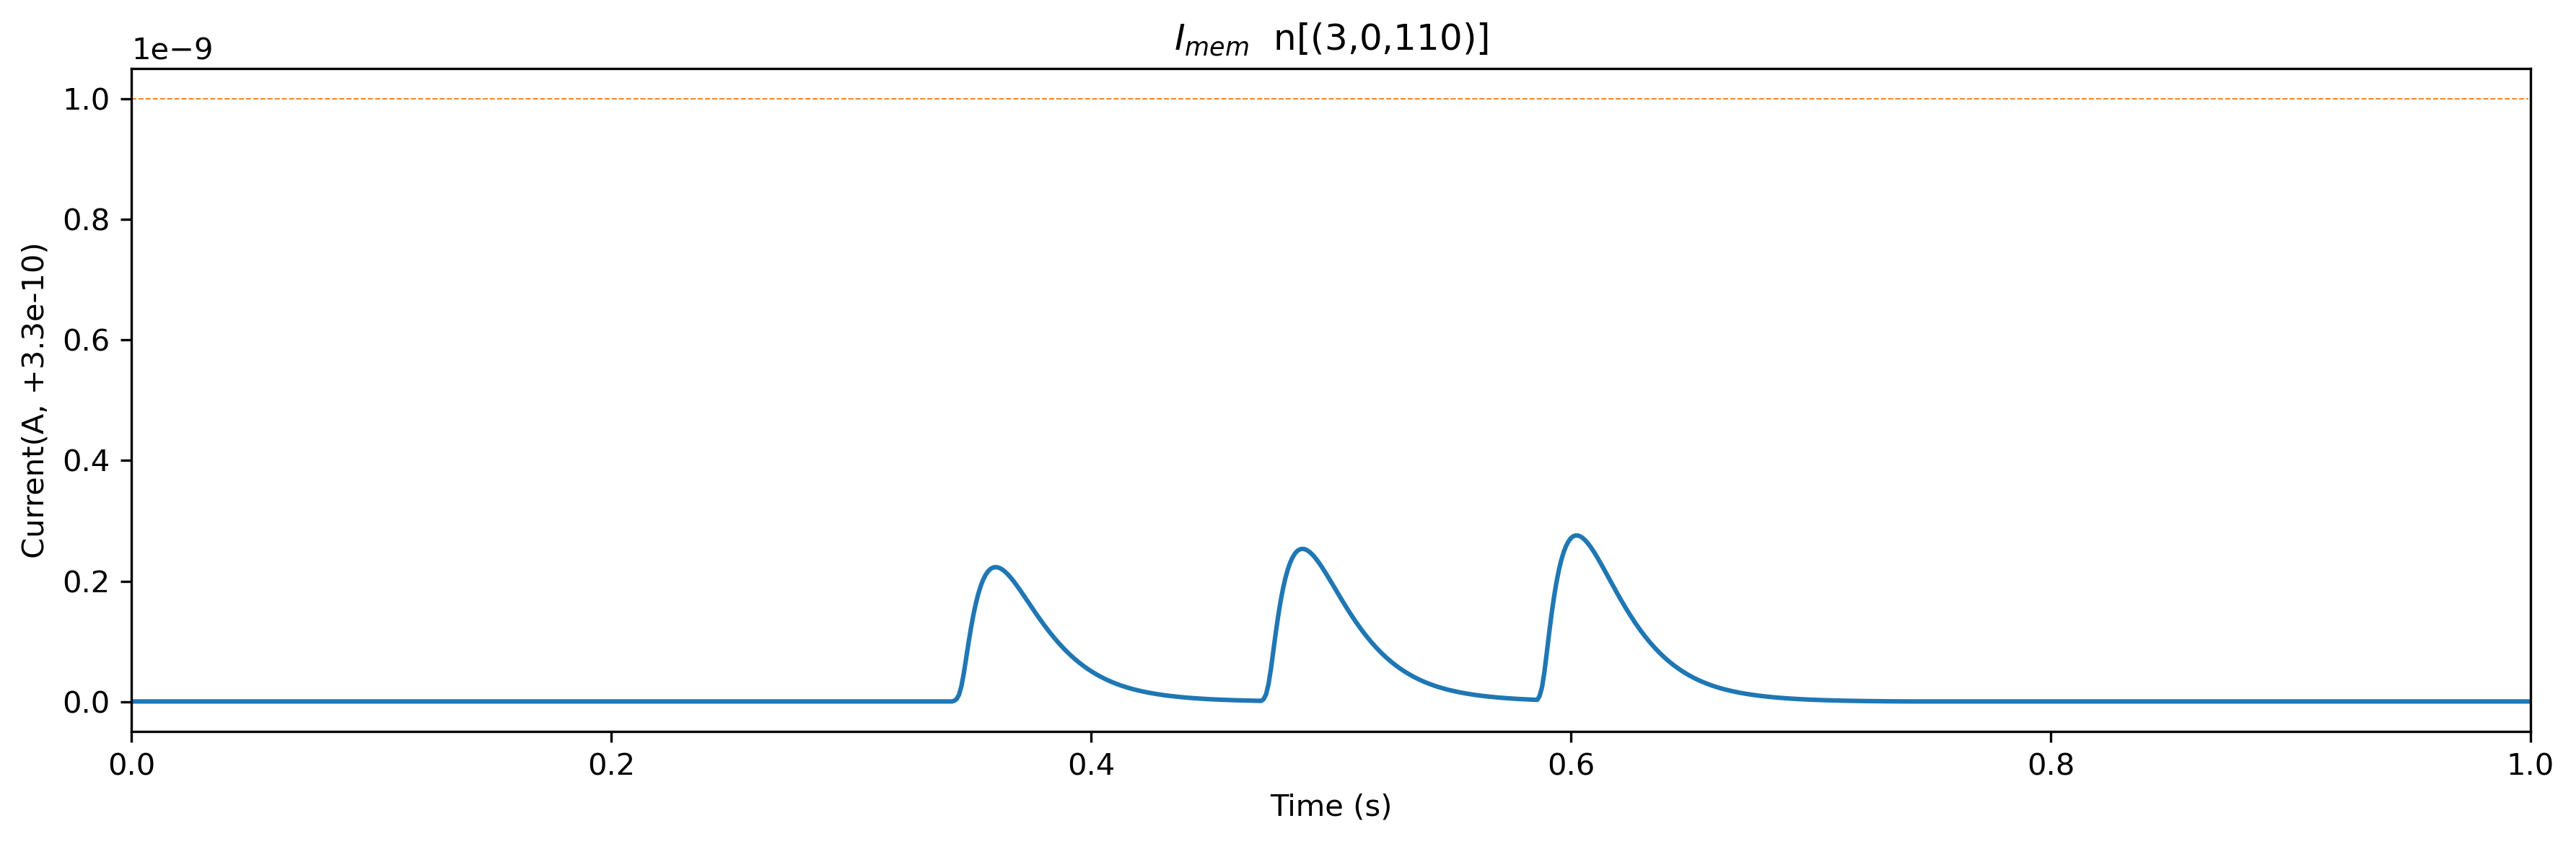

In [14]:
Figure.plot_Ix(record_dict["Imem"][:,4], modSE.Ispkthr[4], name="$I_{mem}$  n[(3,0,110)]")

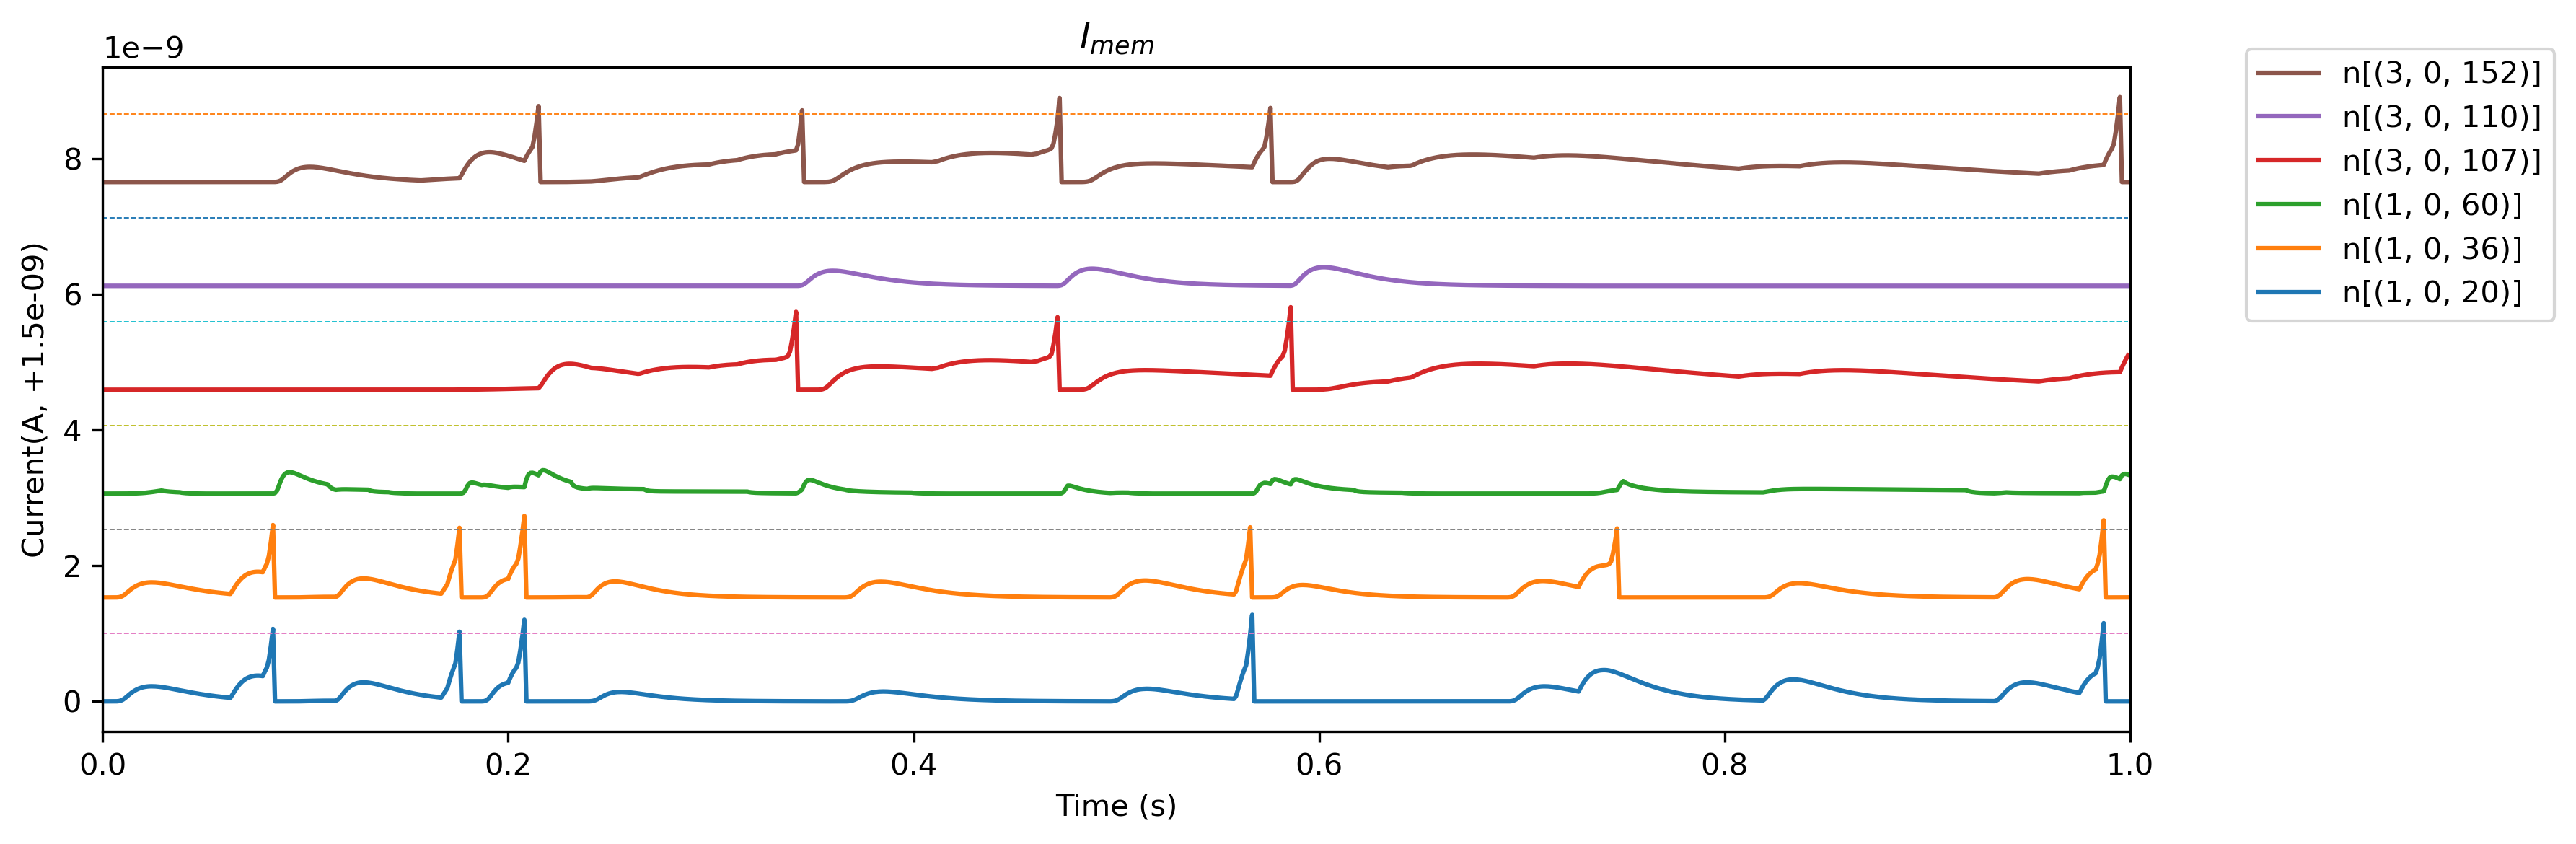

In [15]:
Figure.plot_Ix(record_dict["Imem"], modSE.Ispkthr, name="$I_{mem}$", idx_map=modSE.idx_map_dict['w_rec']);

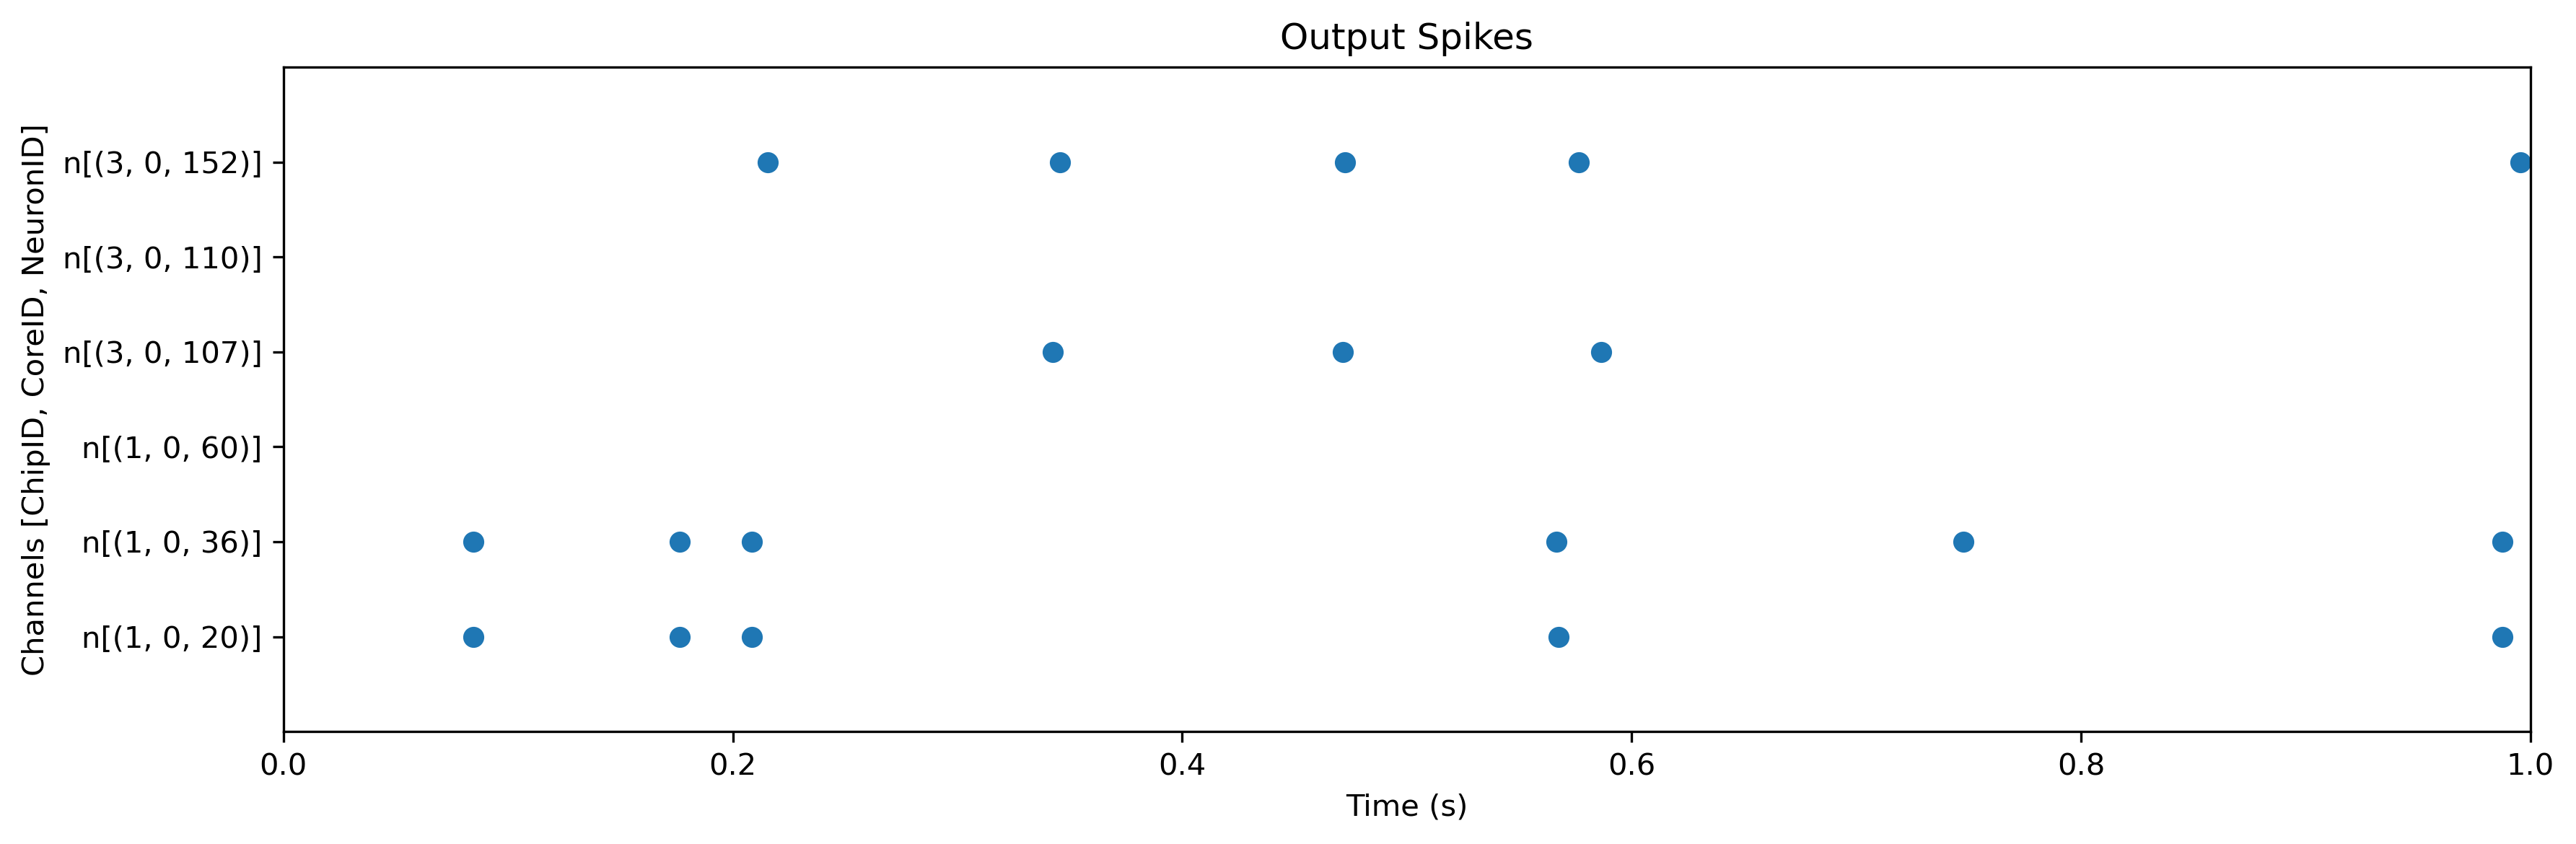

In [16]:
Figure.plot_spikes(out_spikes, name="Output Spikes", idx_map=modSE.idx_map_dict['w_rec']);

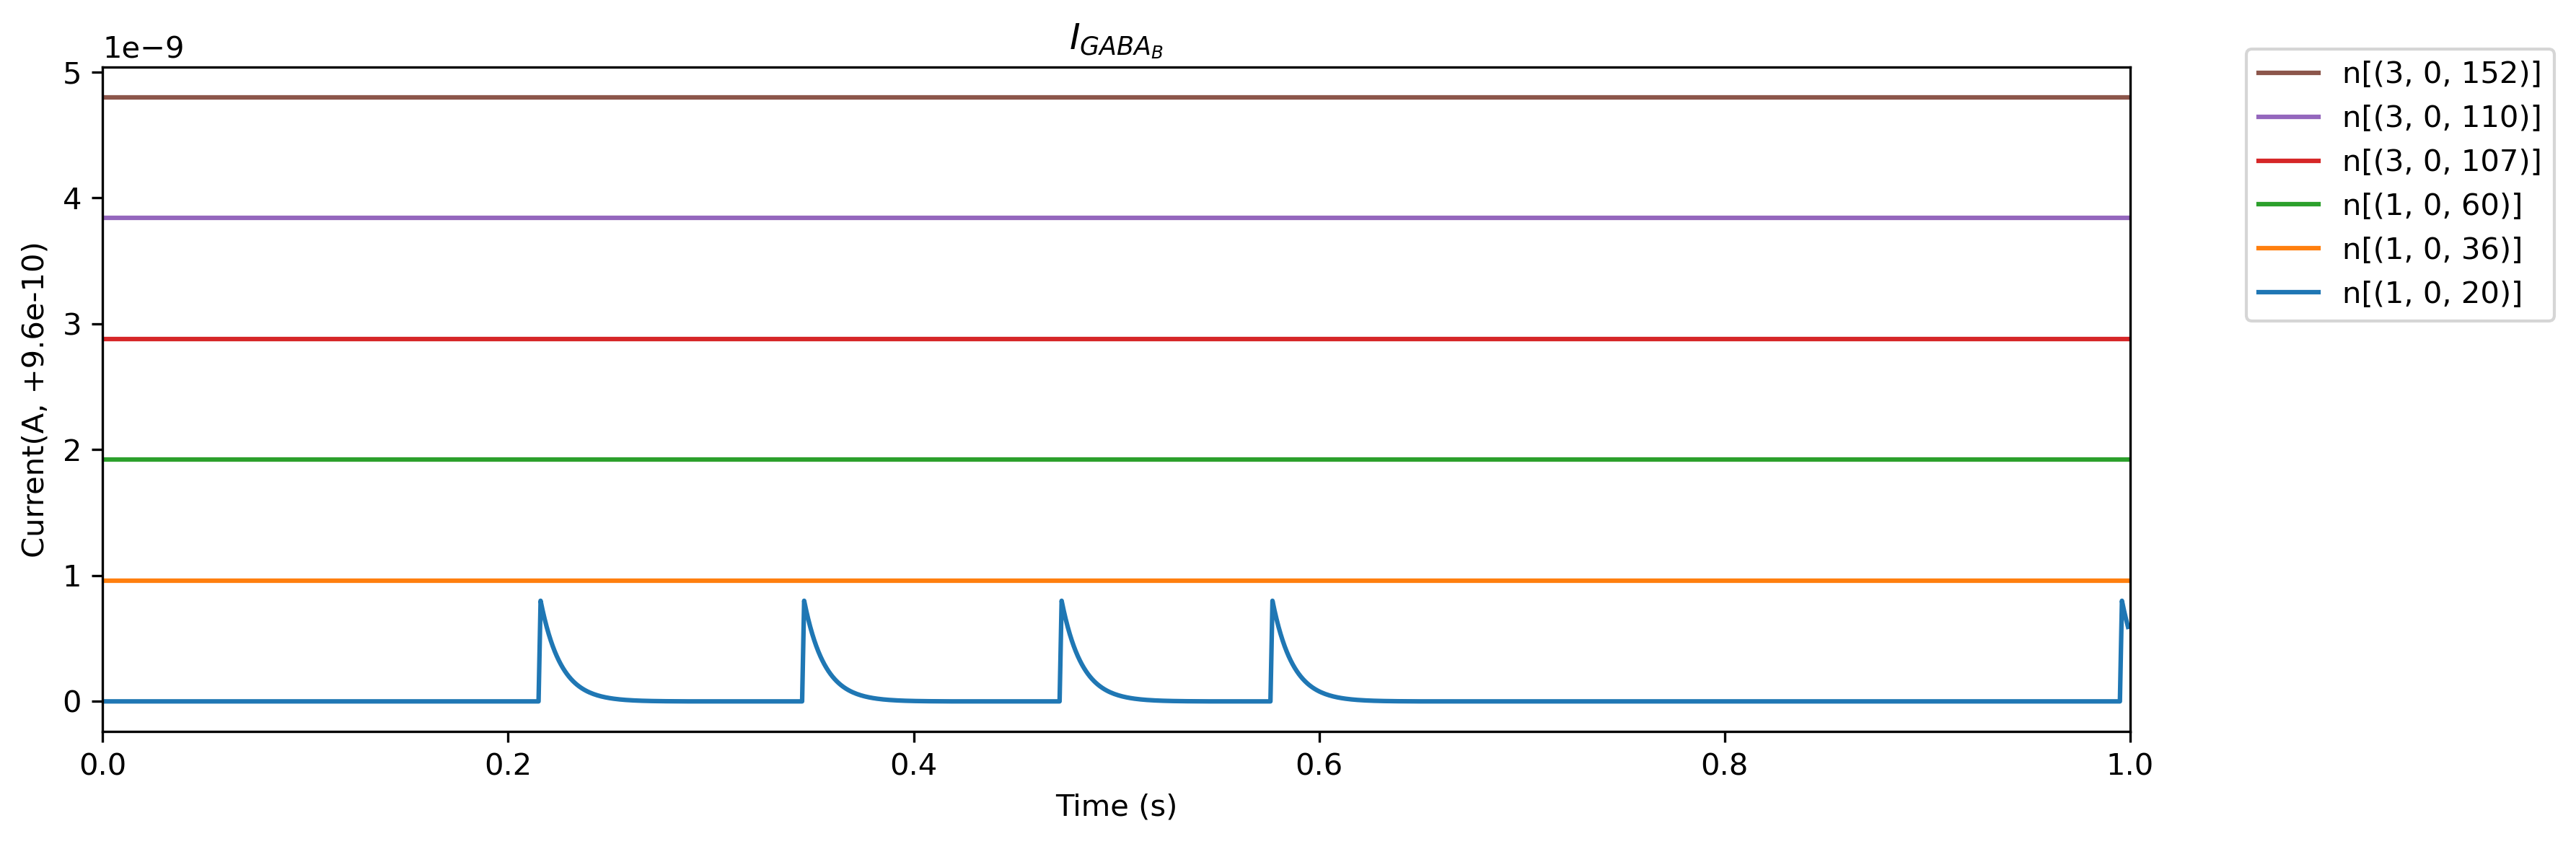

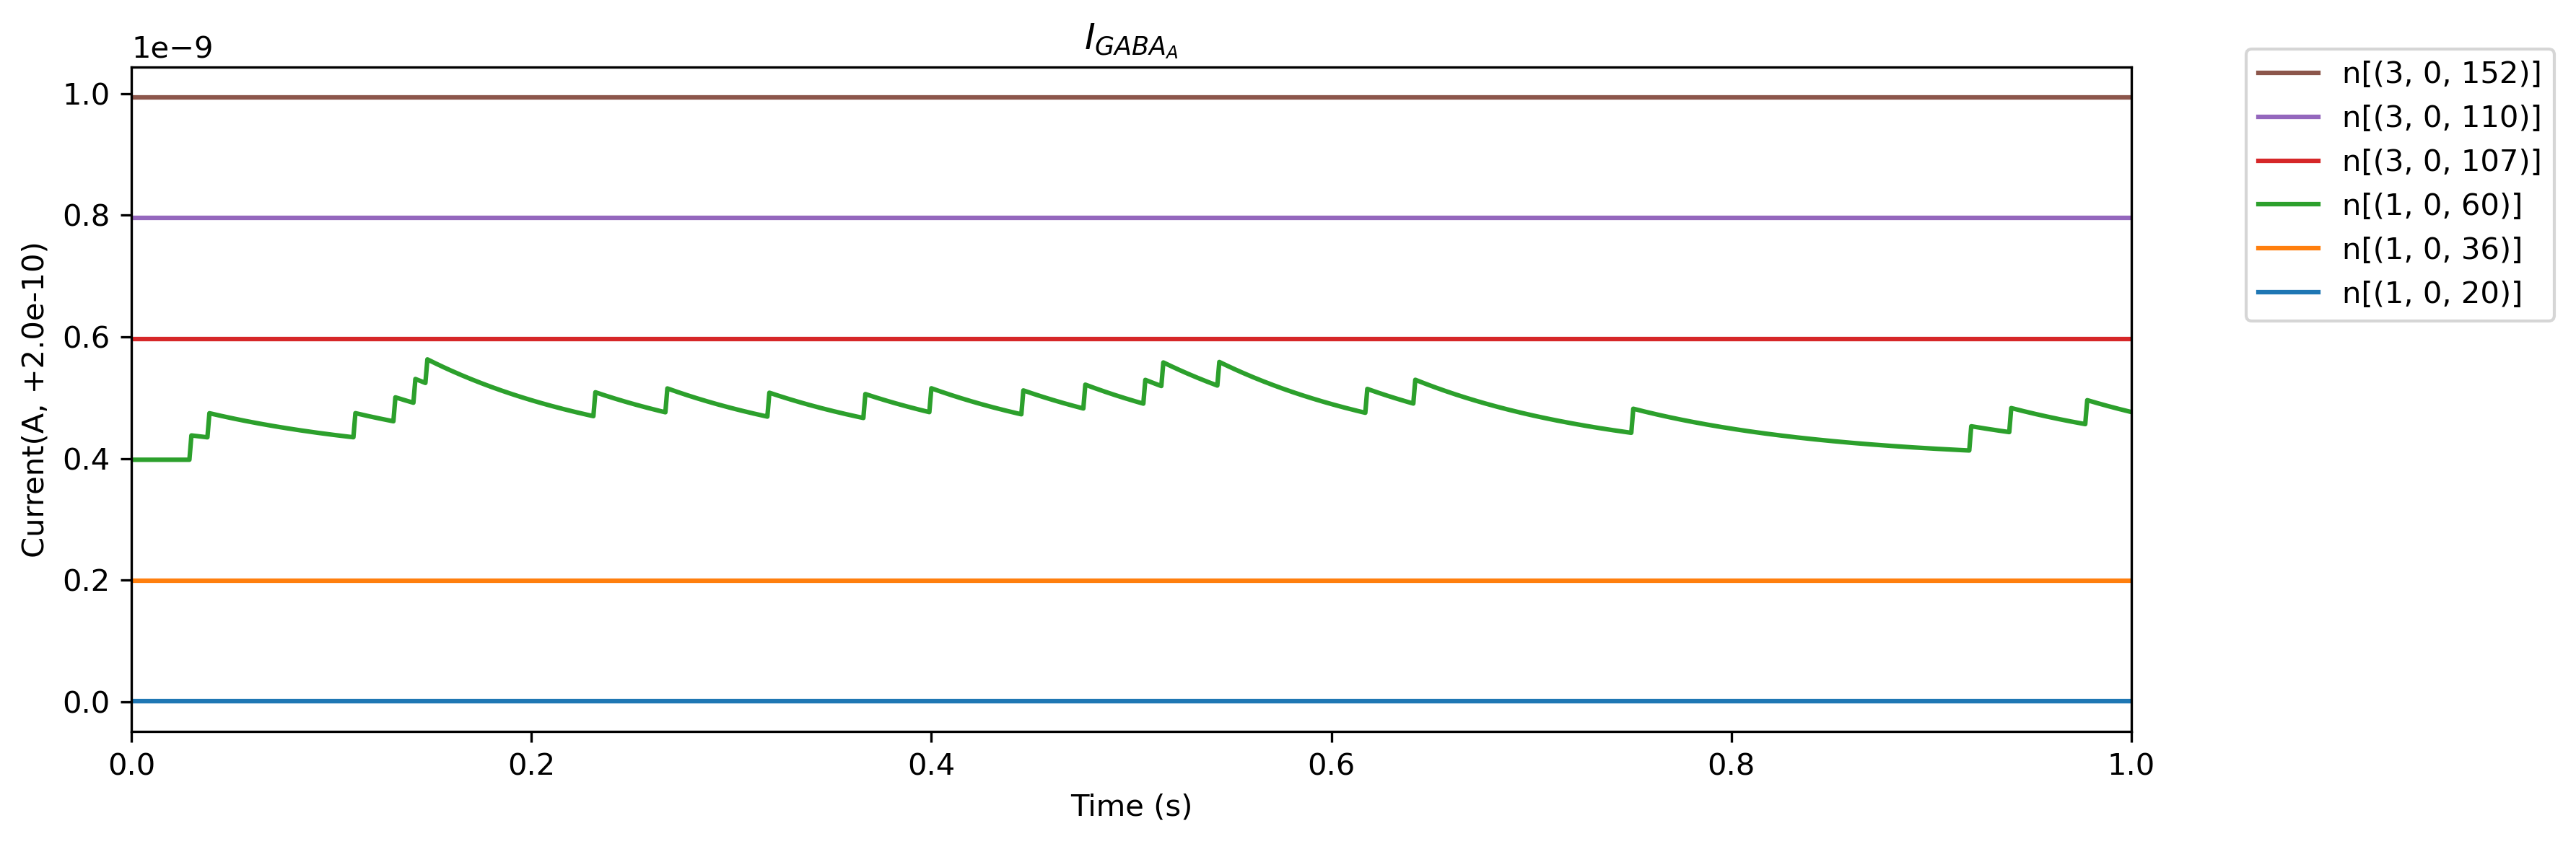

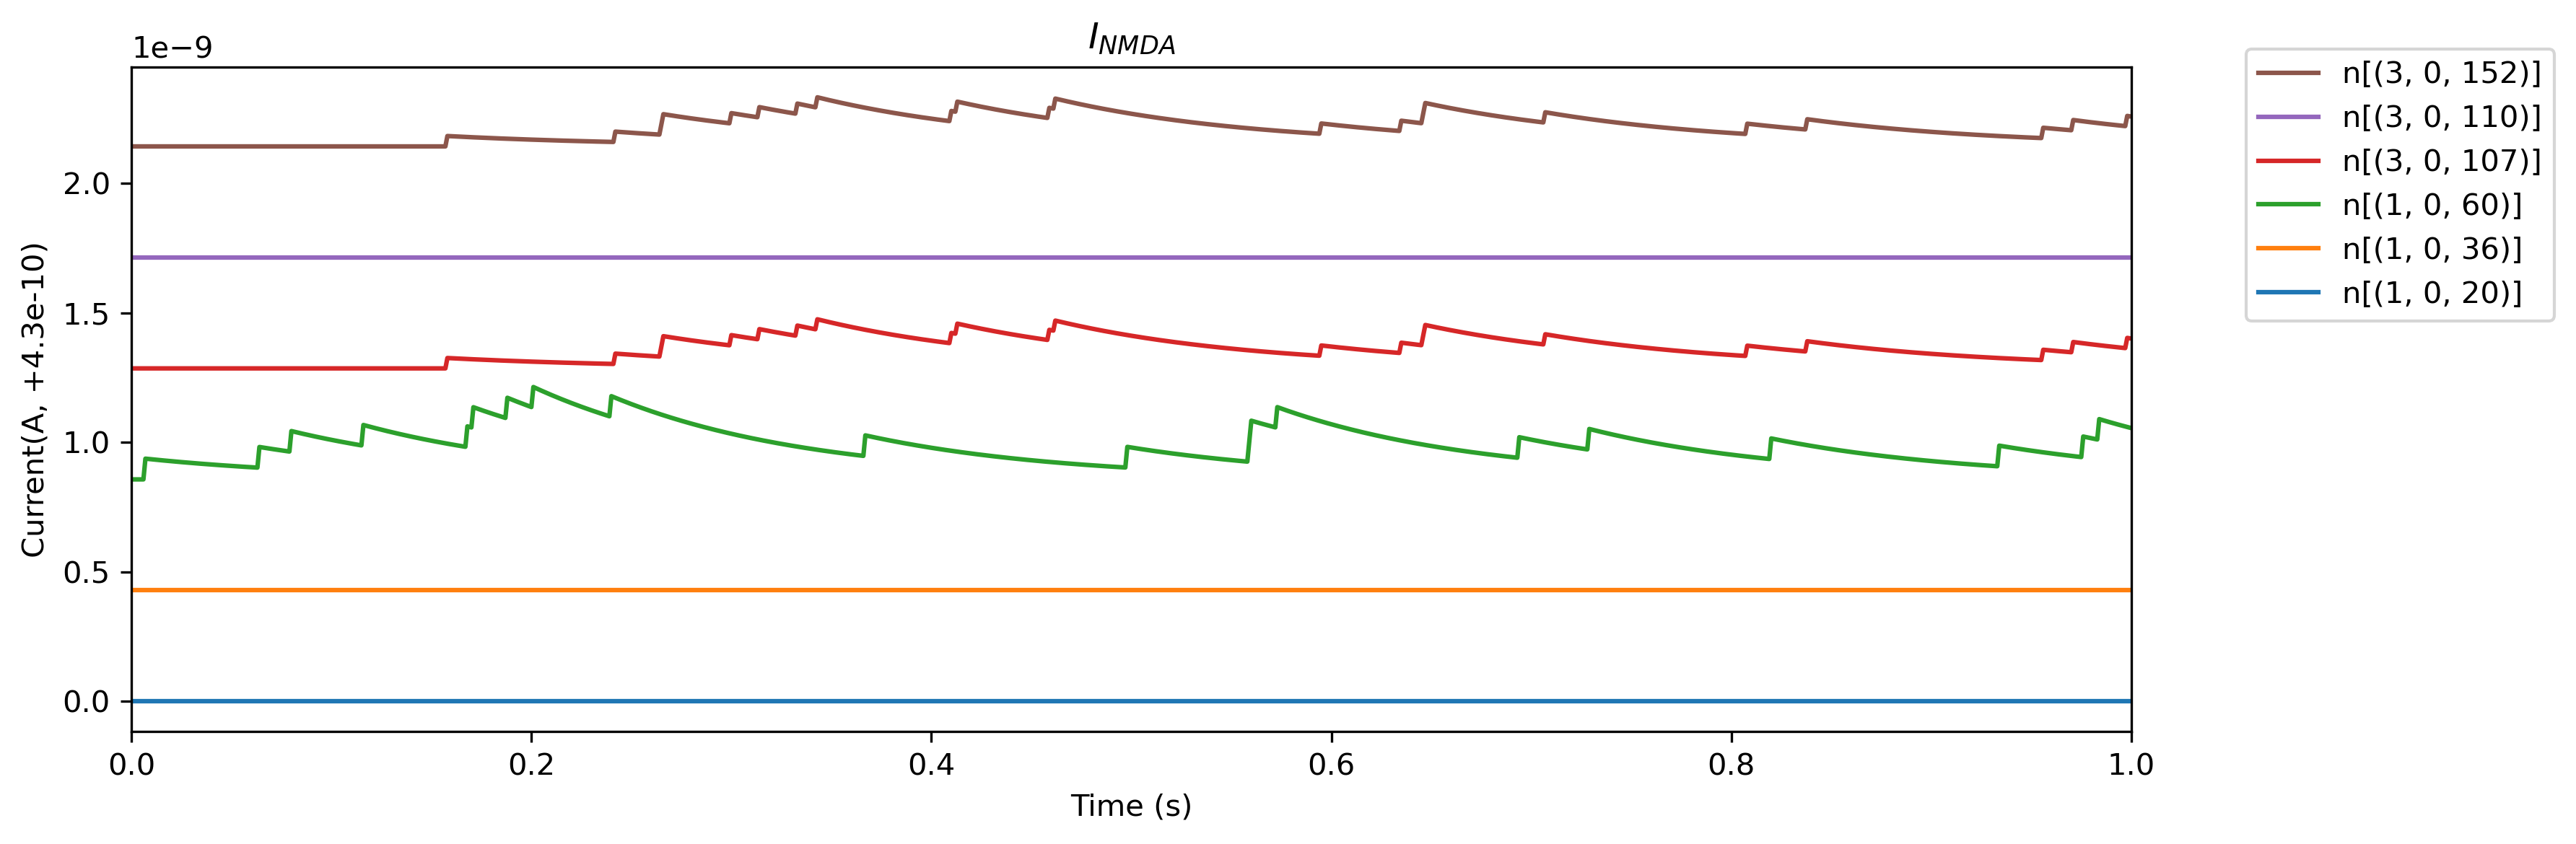

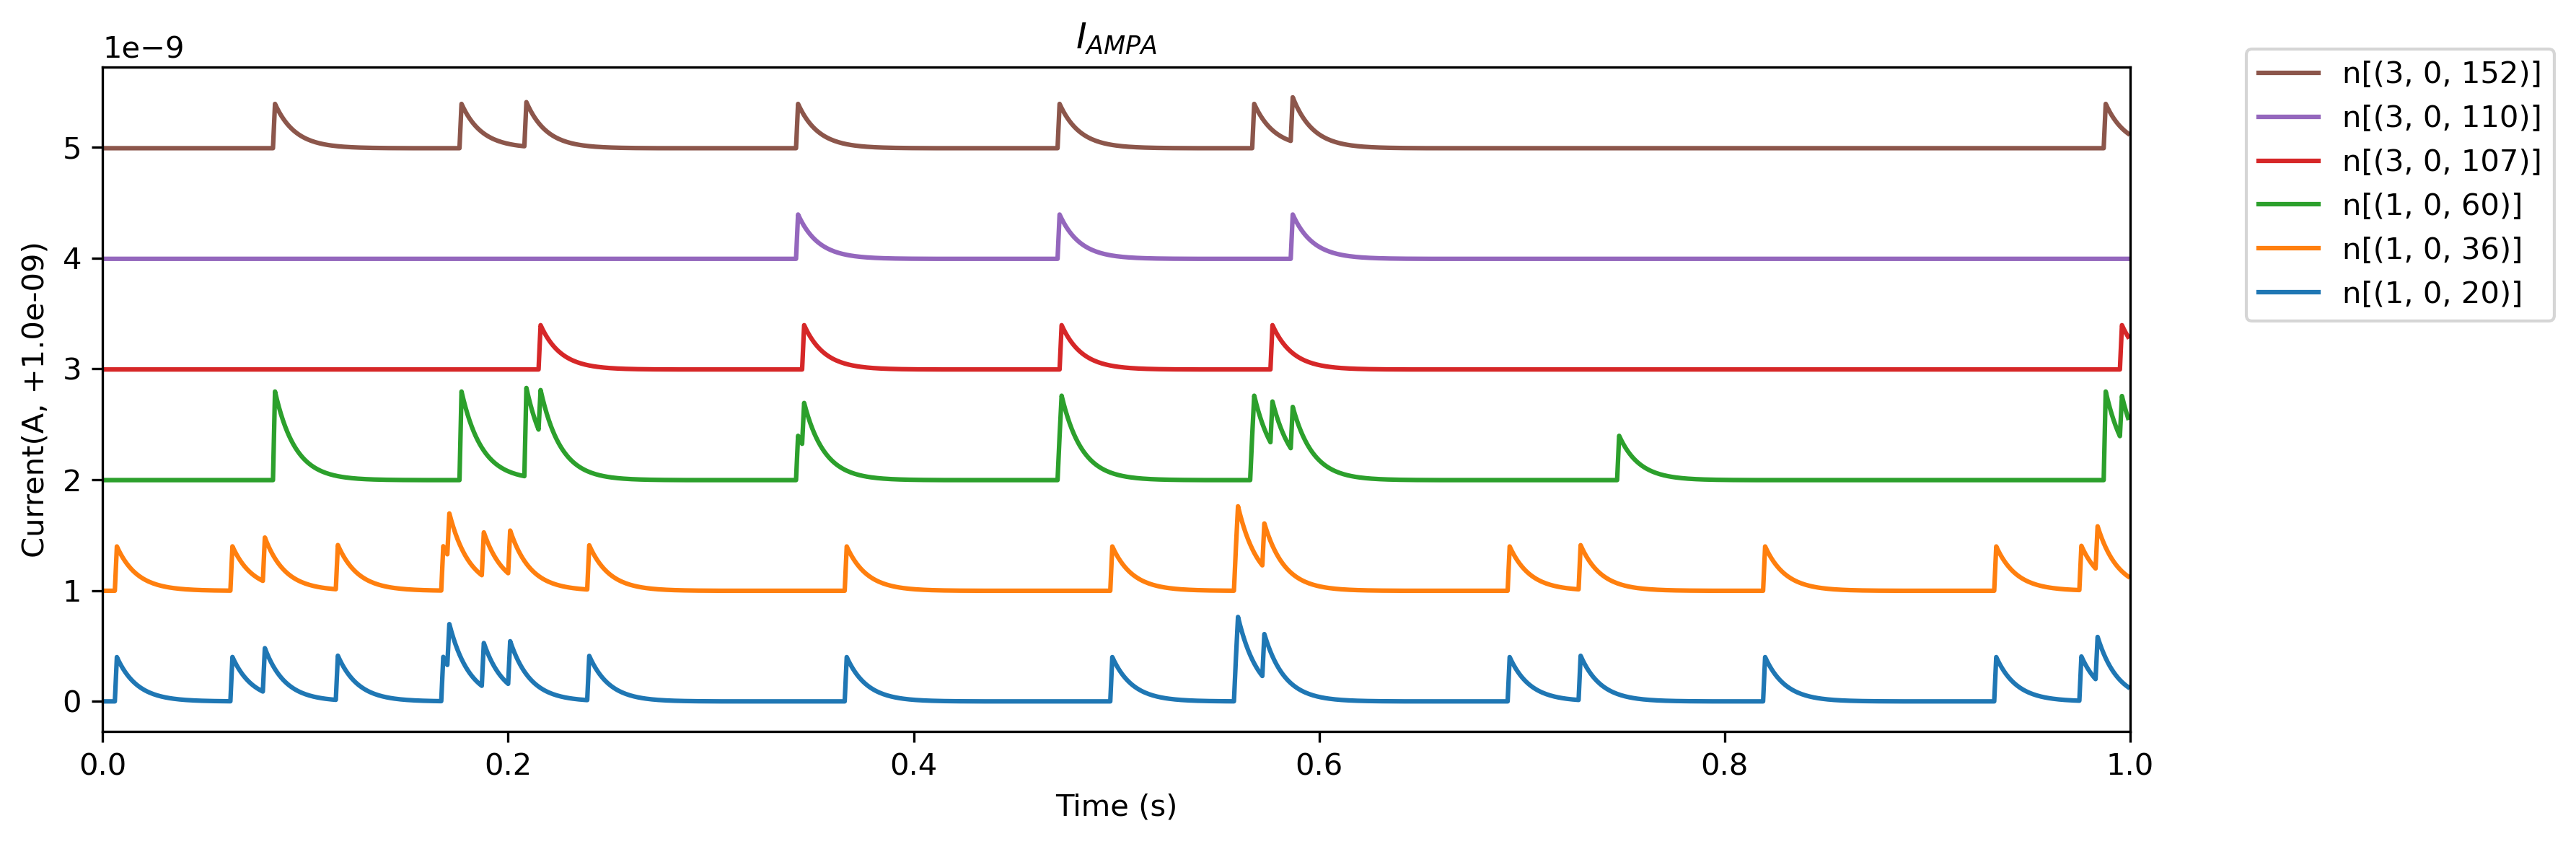

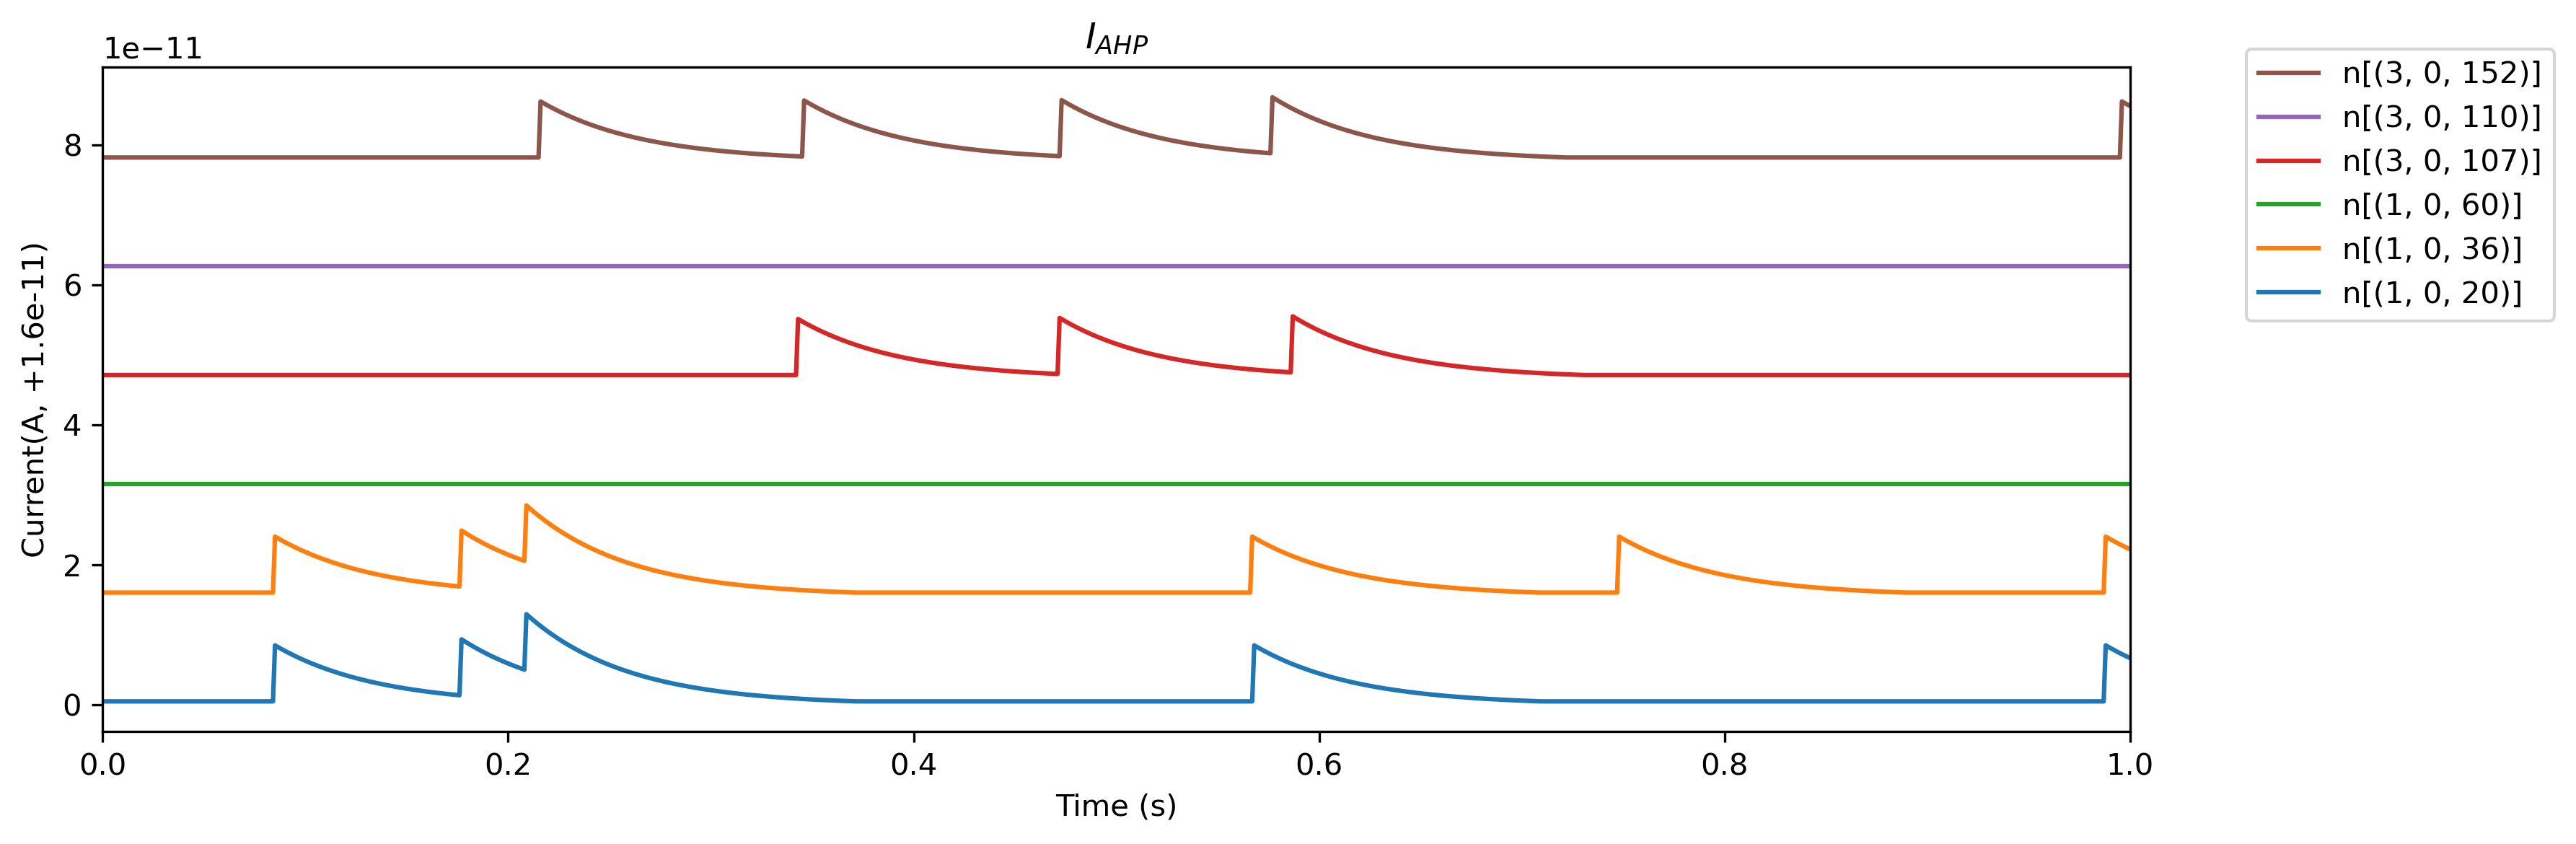

In [17]:
for c in modSE.syn_types:
    plt.figure()
    Figure.plot_Ix(record_dict[f"I{c.lower()}"], name=f"$I_{{{c}}}$", idx_map=modSE.idx_map_dict['w_rec']);

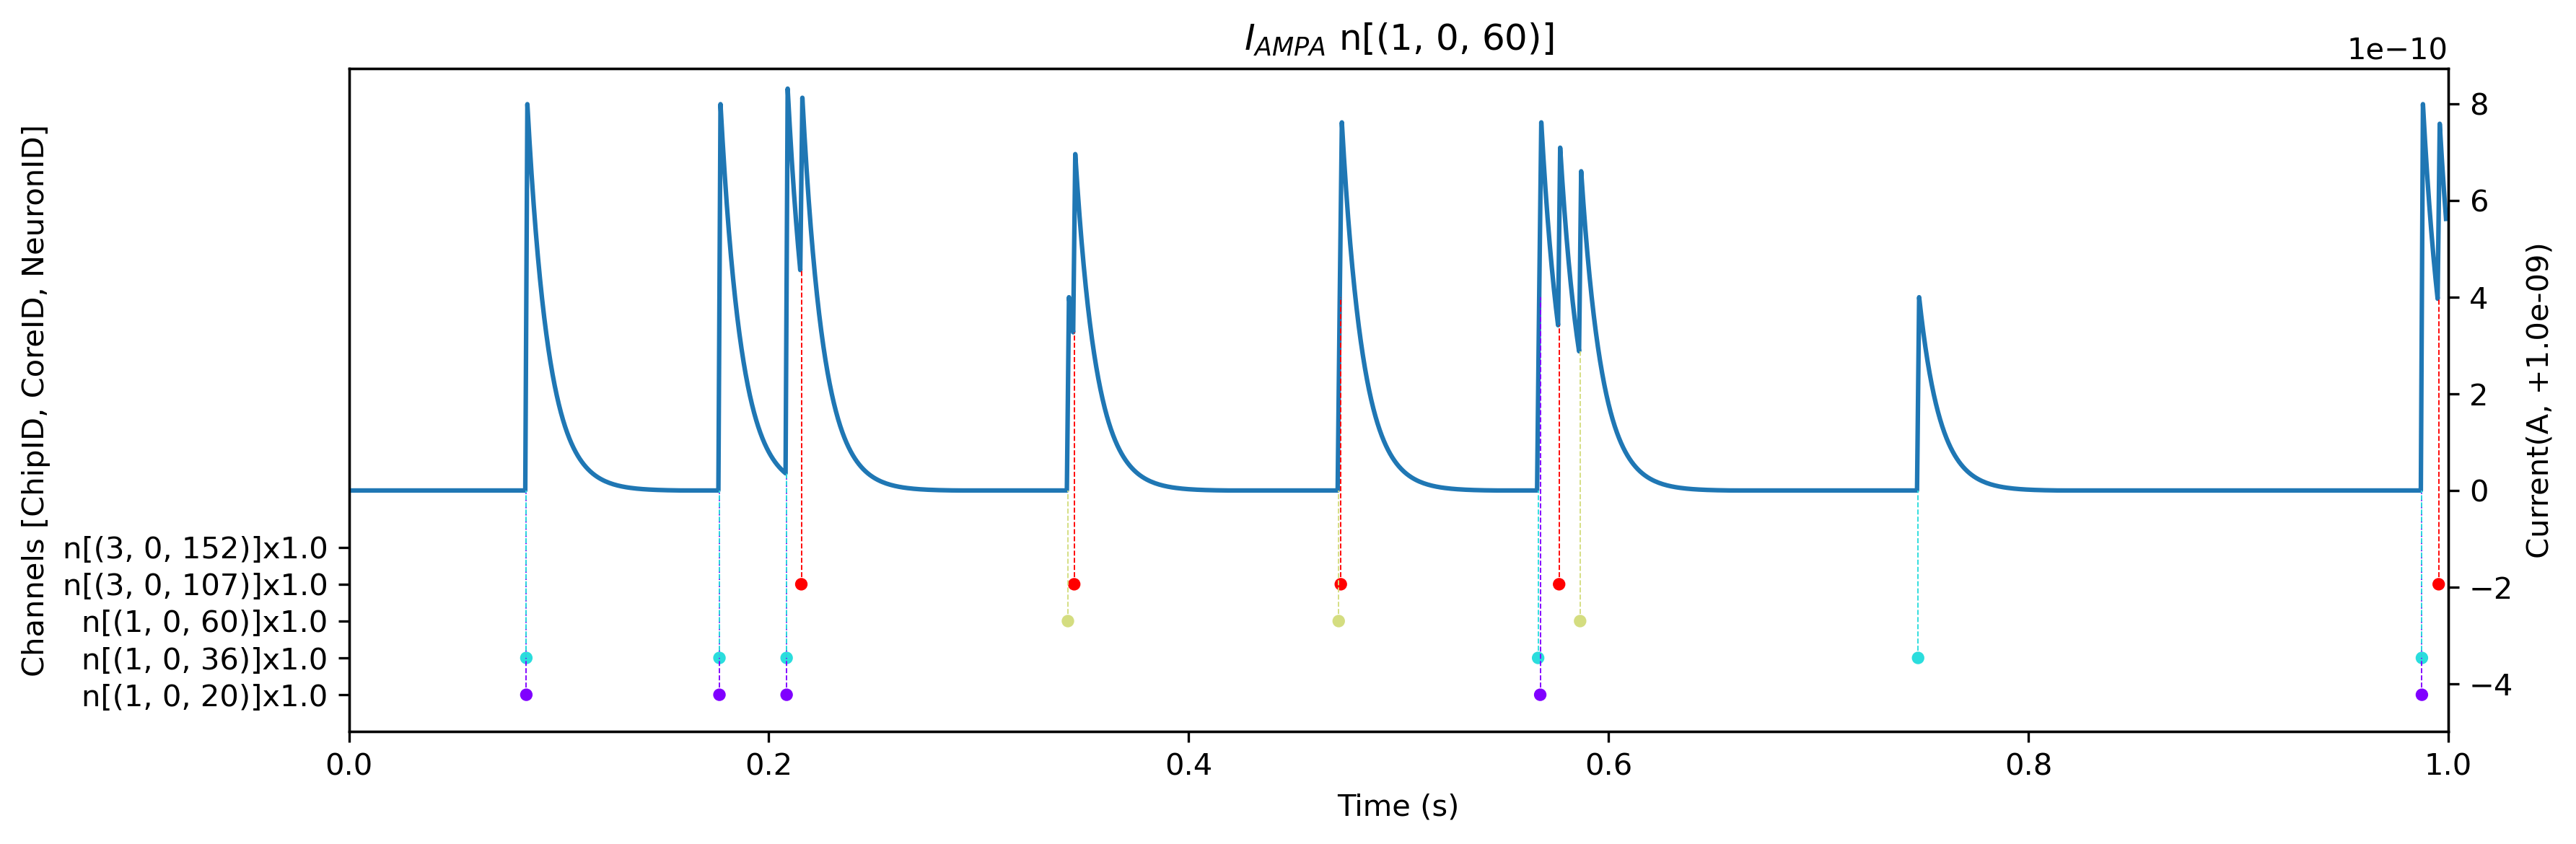

In [29]:
Figure.plot_Isyn_trace(modSE, record_dict, (1,0,60), "ampa", idx_map_dict=modSE.idx_map_dict);

## Deployment Help

In [19]:
modSE.core_dict

{(1, 0): {0: 20, 1: 36, 2: 60}, (3, 0): {3: 107, 4: 110, 5: 152}}

In [20]:
print(modSE.samna_param_group(1,0).to_json())

{
    "value0": {
        "paramMap": [
            {
                "key": "IF_AHTAU_N",
                "value": {
                    "paramName": "IF_AHTAU_N",
                    "coarseValue": 1,
                    "fineValue": 69,
                    "type": "N"
                }
            },
            {
                "key": "IF_AHTHR_N",
                "value": {
                    "paramName": "IF_AHTHR_N",
                    "coarseValue": 2,
                    "fineValue": 35,
                    "type": "N"
                }
            },
            {
                "key": "IF_AHW_P",
                "value": {
                    "paramName": "IF_AHW_P",
                    "coarseValue": 5,
                    "fineValue": 64,
                    "type": "P"
                }
            },
            {
                "key": "IF_BUF_P",
                "value": {
                    "paramName": "IF_BUF_P",
                    "coarseValue": 4,
          

In [21]:
print(modSE.samna_param_group(3,0).to_json())

{
    "value0": {
        "paramMap": [
            {
                "key": "IF_AHTAU_N",
                "value": {
                    "paramName": "IF_AHTAU_N",
                    "coarseValue": 1,
                    "fineValue": 69,
                    "type": "N"
                }
            },
            {
                "key": "IF_AHTHR_N",
                "value": {
                    "paramName": "IF_AHTHR_N",
                    "coarseValue": 2,
                    "fineValue": 35,
                    "type": "N"
                }
            },
            {
                "key": "IF_AHW_P",
                "value": {
                    "paramName": "IF_AHW_P",
                    "coarseValue": 5,
                    "fineValue": 64,
                    "type": "P"
                }
            },
            {
                "key": "IF_BUF_P",
                "value": {
                    "paramName": "IF_BUF_P",
                    "coarseValue": 4,
          